In [158]:
using NetCDF, PyPlot, BitInformation
using TranscodingStreams, CodecZstd
using ZfpCompression

In [84]:
ZstdCompressorL10 = ZstdCompressor(level=10)
TranscodingStreams.initialize(ZstdCompressorL10)

ZstdCompressorL22 = ZstdCompressor(level=22)
TranscodingStreams.initialize(ZstdCompressorL22)

In [19]:
path= "/gf3/sat_data/SAT012_AQUATERRA_MODIS_L20_GLOBAL/viirs_I_20210513_t2342292.nc"
ncfile = NetCDF.open(path)
I04 = ncfile.vars["I04"][2800:6500,500:5500]
I05 = ncfile.vars["I05"][2800:6500,500:5500];

In [100]:
ncfile


##### NetCDF File #####

/gf3/sat_data/SAT012_AQUATERRA_MODIS_L20_GLOBAL/viirs_I_20210513_t2342292.nc

##### Dimensions #####

Name                                                Length                    
--------------------------------------------------------------------------------
x                                                   9117                      
y                                                   6758                      

##### Variables #####

Name                            Type            Dimensions                      
--------------------------------------------------------------------------------
I05                             FLOAT           x y                             
latitude                        DOUBLE          x y                             
I02                             FLOAT           x y                             
longitude                       DOUBLE          x y                             
laea_otf                        INT         

In [40]:
# Information
bi04 = bitinformation(I04)
bi05 = bitinformation(I05);

In [148]:
# filter
bi04filt = [if b > maximum(bi04[25:end]) b else 0.0 end for b in bi04]
bi05filt = [if b > maximum(bi05[25:end]) b else 0.0 end for b in bi05]

p = 0.99
keepbits04 = argmax(cumsum(bi04filt)/sum(bi04filt) .>= p) - 9
keepbits05 = argmax(cumsum(bi05filt)/sum(bi05filt) .>= p) - 9

9

In [149]:
keepbits04

9

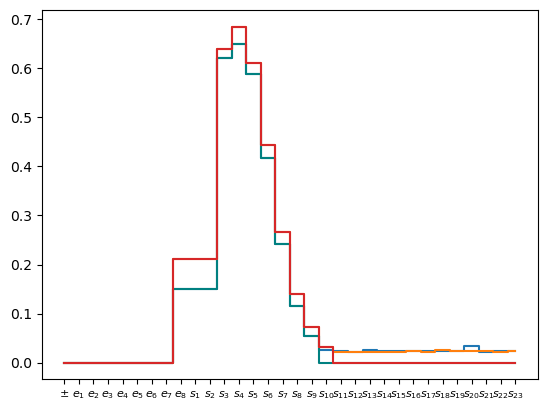

In [136]:
plot(1:32,bi04,"C0",ds="steps-mid")
plot(1:32,bi04filt,"teal",ds="steps-mid")

plot(1:32,bi05,"C1",ds="steps-mid")
plot(1:32,bi05filt,"C3",ds="steps-mid")

xticks(1:32,vcat("±",[L"e_%$i" for i in 1:8],                           # label sign, exponent and significant bits
        [L"s_{%$i}" for i in 1:23]),fontsize=8);

# Compression

In [150]:
I04r = round(I04,keepbits04)
I05r = round(I05,keepbits05);

In [151]:
comp_fac04 = sizeof(I04)/sizeof(transcode(ZstdCompressorL10,copy(reinterpret(UInt8,vec(I04r)))))

6.845822442188316

In [152]:
comp_fac05 = sizeof(I05)/sizeof(transcode(ZstdCompressorL10,copy(reinterpret(UInt8,vec(I05r)))))

7.1163998486265125

In [ ]:
I04z = zfp_decompress(zfp_compress(I04,tol=1e-1)

In [164]:
sort(unique(I04r))[150:170]

21-element Vector{Float32}:
 252.25
 252.5
 252.75
 253.0
 253.25
 253.5
 253.75
 254.0
 254.25
 254.5
 254.75
 255.0
 255.25
 255.5
 255.75
 256.0
 256.5
 257.0
 257.5
 258.0
 258.5

# Plotting

In [153]:
using ColorSchemes, Statistics, StatsBase
cmap = ColorMap(ColorSchemes.roma.colors).reversed()

In [154]:
vmin4,vmax4 = quantile(vec(I04),[0.01,0.99])
vmin5,vmax5 = quantile(vec(I05),[0.01,0.99])
vmin = min(vmin4,vmin5)
vmax = max(vmax4,vmax5)

293.4291076660156

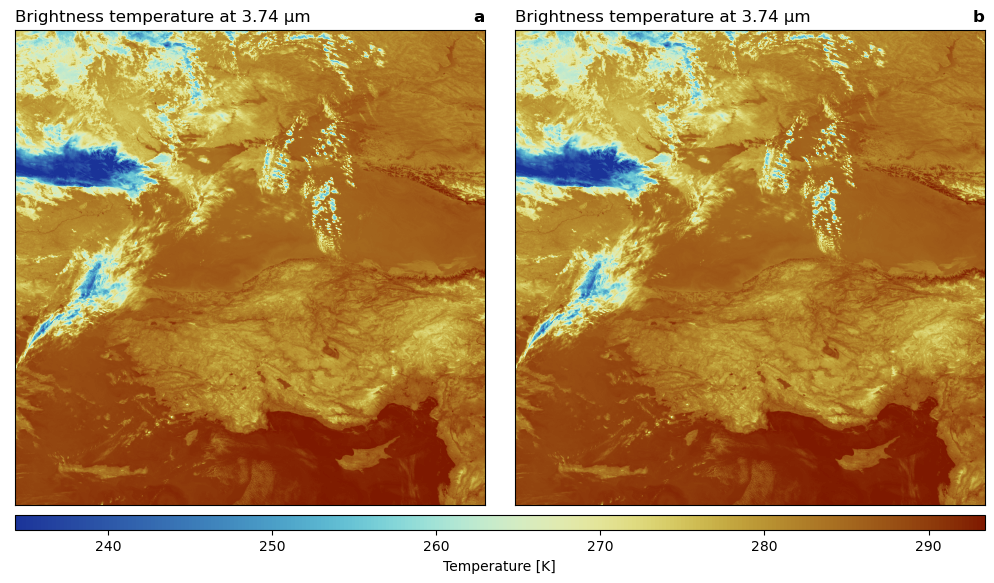

PyObject Text(0.0, 1.0, 'Brightness temperature at 3.74 µm')

In [173]:
fig = figure(figsize=(10,5))
ax1 = fig.add_axes(rect=[0.02,0.1,0.47,0.95])
ax2 = fig.add_axes(rect=[0.52,0.1,0.47,0.95])
axs = (ax1,ax2)

pos1 = ax1.get_position()
pos2 = ax2.get_position()
cax = fig.add_axes([pos1.x0,pos1.y0-0.05,pos2.x1-pos1.x0,0.03])

q = axs[1].imshow(I04r',aspect="auto";cmap,vmin,vmax)
axs[2].imshow(I04',aspect="auto";cmap,vmin,vmax)
cbar = colorbar(q,cax=cax,orientation="horizontal",label="Temperature [K]")

axs[1].set_xticks([])
axs[1].set_yticks([])

for (iax,ax) in enumerate(axs)
    ax.set_title(string(Char(iax+96)),loc="right",fontweight="bold")
    ax.set_xticks([])
    ax.set_yticks([])
end

axs[1].set_title("Brightness temperature at 3.74 µm",loc="left")
axs[2].set_title("Brightness temperature at 3.74 µm",loc="left")


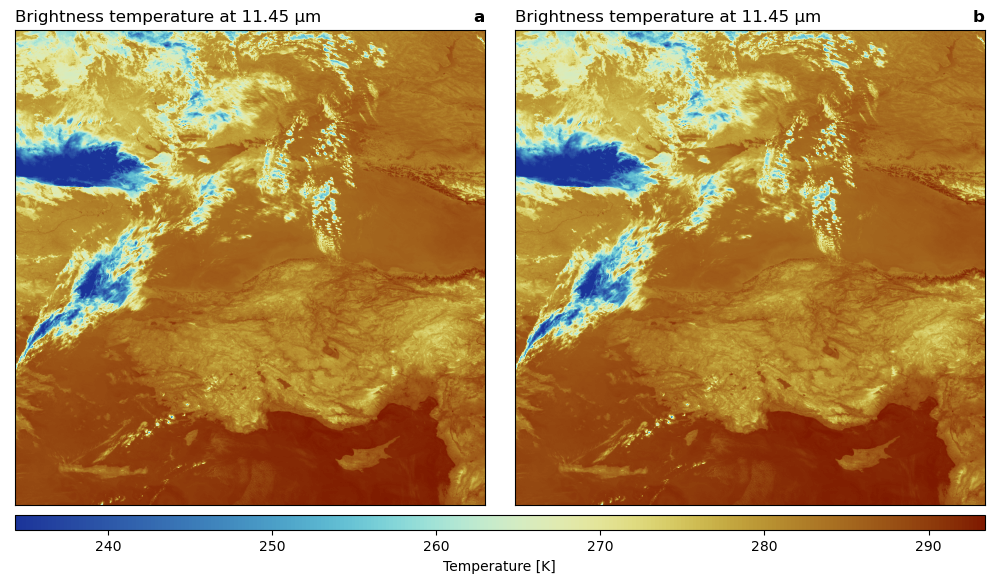

PyObject Text(0.0, 1.0, 'Brightness temperature at 11.45 µm')

In [174]:
fig = figure(figsize=(10,5))
ax1 = fig.add_axes(rect=[0.02,0.1,0.47,0.95])
ax2 = fig.add_axes(rect=[0.52,0.1,0.47,0.95])
axs = (ax1,ax2)

pos1 = ax1.get_position()
pos2 = ax2.get_position()
cax = fig.add_axes([pos1.x0,pos1.y0-0.05,pos2.x1-pos1.x0,0.03])

q = axs[1].imshow(I05r',aspect="auto";cmap,vmin,vmax)
axs[2].imshow(I05',aspect="auto";cmap,vmin,vmax)
cbar = colorbar(q,cax=cax,orientation="horizontal",label="Temperature [K]")

axs[1].set_xticks([])
axs[1].set_yticks([])


for (iax,ax) in enumerate(axs)
    ax.set_title(string(Char(iax+96)),loc="right",fontweight="bold")
    ax.set_xticks([])
    ax.set_yticks([])
end

axs[1].set_title("Brightness temperature at 11.45 µm",loc="left")
axs[2].set_title("Brightness temperature at 11.45 µm",loc="left")